In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path

print(Path().cwd())
os.chdir(Path(os.getcwd()).parent)
print(Path().cwd())

/home/das/QuantUS_Projs/QuantUS-Plugins-CEUS/CLI-Demos
/home/das/QuantUS_Projs/QuantUS-Plugins-CEUS


## Select Contrast-Enhanced Ultrasound (CEUS) Cine and Parser

In [2]:
from src.image_loading.options import get_scan_loaders

print("Available scan loaders:", list(get_scan_loaders().keys()))

Available scan loaders: ['nifti']


In [3]:
scan_type = 'nifti'

scan_path = '/media/das/TOSHIBA EXT/P-Selectin Data/Feb 2019 Mice Batch 1/Mouse01D02batch1_02152019/MouseC2M2_d02_02152019/20190215144608.915.nii.gz'
scan_loader_kwargs = {
    'transpose': False,
}

In [4]:
from src.entrypoints import scan_loading_step

image_data = scan_loading_step(scan_type, scan_path, **scan_loader_kwargs)

## Load Segmentation

Assumes same segmentation for each frame

In [5]:
from src.seg_loading.options import get_seg_loaders

print("Available segmentation loaders:", list(get_seg_loaders().keys()))

Available segmentation loaders: ['nifti_voi', 'load_bolus_mask']


In [29]:
seg_type = 'nifti_voi'

seg_path = '/media/das/TOSHIBA EXT/P-Selectin Data/Feb VOIs (David)/20190215144608.915_segmentation_LEFT.nii.gz'
seg_loader_kwargs = {}

In [30]:
from src.entrypoints import seg_loading_step

seg_data = seg_loading_step(seg_type, image_data, seg_path, scan_path, **seg_loader_kwargs)

## CEUS Quantitative Temporal Curve Analysis

In [31]:
from src.ttc_analysis.options import get_analysis_types, get_required_kwargs

all_analysis_types, all_analysis_funcs = get_analysis_types()
print("Available analysis types:", list(all_analysis_types.keys()))

Available analysis types: ['ttc_curves']


In [32]:
analysis_type = 'ttc_curves'

print("Available analysis functions:", list(all_analysis_funcs[analysis_type].keys()))

Available analysis functions: ['pyradiomics', 'tic']


In [33]:
analysis_funcs = ['tic', 'pyradiomics']

# Find all required kwargs for the analysis functions
analysis_funcs = analysis_funcs if len(analysis_funcs) else list(all_analysis_funcs[analysis_type].keys())
required_kwargs = get_required_kwargs(analysis_type, analysis_funcs)
print("Required kwargs for current analysis:", required_kwargs)

Required kwargs for current analysis: ['pyradiomics_config_paths']


In [34]:
analysis_kwargs = {
    'pyradiomics_config_paths': [
        '/home/das/QuantUS_Projs/QuantUS-Plugins-CEUS/configs/pyradiomics/moderate-pselectin.yml',
    ],
    'curves_output_path': 'test_LEFT.csv',
}

In [35]:
from src.entrypoints import analysis_step

analysis_obj = analysis_step(analysis_type, image_data, seg_data, analysis_funcs, **analysis_kwargs)

Computing curves: 100%|██████████| 384/384 [00:21<00:00, 17.91it/s]


In [ ]:
import pandas as pd

df_left = pd.read_csv('test_LEFT.csv')
df_right = pd.read_csv('test_RIGHT.csv')

In [37]:
df_left.head()

,Scan Name,Segmentation Name,Time Array,TIC,moderate-pselectin_diagnostics_Image-original_Mean,moderate-pselectin_diagnostics_Image-original_Minimum,moderate-pselectin_diagnostics_Image-original_Maximum,moderate-pselectin_diagnostics_Mask-original_VoxelNum,moderate-pselectin_diagnostics_Mask-original_VolumeNum,moderate-pselectin_diagnostics_Image-interpolated_Mean,...,moderate-pselectin_original_gldm_LargeDependenceLowGrayLevelEmphasis,moderate-pselectin_original_gldm_LowGrayLevelEmphasis,moderate-pselectin_original_gldm_SmallDependenceEmphasis,moderate-pselectin_original_gldm_SmallDependenceHighGrayLevelEmphasis,moderate-pselectin_original_gldm_SmallDependenceLowGrayLevelEmphasis,moderate-pselectin_original_ngtdm_Busyness,moderate-pselectin_original_ngtdm_Coarseness,moderate-pselectin_original_ngtdm_Complexity,moderate-pselectin_original_ngtdm_Contrast,moderate-pselectin_original_ngtdm_Strength
0,20190215144608.915.nii,20190215144608.915_segmentation_LEFT,0.000000,28.045360,9.274426,0.0,232.0,3836,1,21.313281,...,144.463974,0.621710,0.035021,0.259561,0.011080,11.570647,0.012793,5.858626,0.030959,0.192909
1,20190215144608.915.nii,20190215144608.915_segmentation_LEFT,0.388381,32.526330,9.964072,0.0,231.0,3836,1,22.783636,...,73.544553,0.498678,0.035950,0.326932,0.012443,8.697885,0.013602,5.712844,0.029004,0.172821
2,20190215144608.915.nii,20190215144608.915_segmentation_LEFT,0.776762,28.943431,9.249087,0.0,231.0,3836,1,21.512490,...,154.923118,0.622465,0.041849,0.468040,0.008962,7.977904,0.013776,8.972479,0.025470,0.365099
3,20190215144608.915.nii,20190215144608.915_segmentation_LEFT,1.165143,38.465589,9.882621,0.0,231.0,3836,1,21.998735,...,51.153819,0.419625,0.037896,0.426214,0.011239,8.776897,0.015426,5.249009,0.046337,0.148077
4,20190215144608.915.nii,20190215144608.915_segmentation_LEFT,1.553523,29.094108,9.197667,0.0,231.0,3836,1,21.164427,...,141.873776,0.610953,0.041936,0.376157,0.012687,10.919269,0.013255,5.748726,0.031016,0.190269


In [47]:
dest_folder = 'output_curves'
os.makedirs(dest_folder, exist_ok=True)

In [48]:
import matplotlib.pyplot as plt

time_l = df_left['Time Array']
time_r = df_right['Time Array']
for col_name in df_left.columns[2:]:
    fig = plt.figure()
    plt.plot(time_l, df_left[col_name], label='Left VOI (Tx)')
    plt.plot(time_r, df_right[col_name], label='Right VOI (Ctrl)')
    plt.xlabel('Time (s)')
    plt.ylabel(col_name)
    plt.legend()
    fig.savefig(os.path.join(dest_folder, f'{col_name}.png'))
    plt.close(fig)

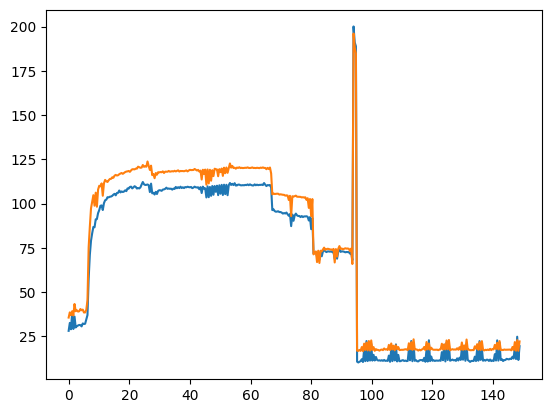

In [ ]:

plt.plot(df_left['Time Array'], df_left['TIC'], label='Left VOI')
plt.plot(df_right['Time Array'], df_right['TIC'], label='Right VOI')

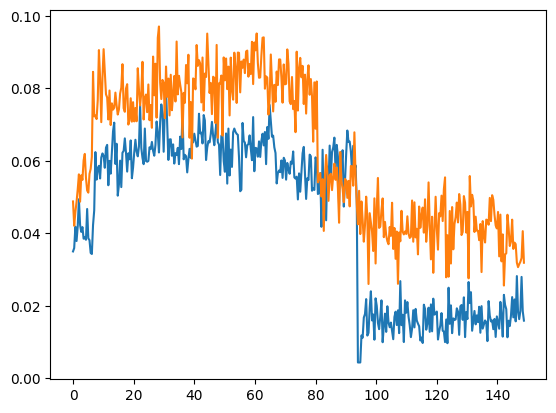

In [46]:
import matplotlib.pyplot as plt

plt.plot(df_left['Time Array'], df_left['moderate-pselectin_original_gldm_SmallDependenceEmphasis'], label='Left VOI')
plt.plot(df_right['Time Array'], df_right['moderate-pselectin_original_gldm_SmallDependenceEmphasis'], label='Right VOI')

## Curve Quantification

In [13]:
from src.curve_quantification.options import get_quantification_funcs

quantification_funcs = get_quantification_funcs()
print("Available quantification functions:", quantification_funcs.keys())

Available quantification functions: dict_keys(['cmus_firstorder', 'dte', 'first_order', 'lognormal_fit', 'wash_rates'])


In [14]:
function_names = [] # Empty list will use all functions
output_path = 'test_quants.csv'
curve_quantifications_kwargs = {
    'curves_to_fit': ['moderate-pselectin_diagnostics_Image-original_Mean'],
    'n_frames_to_analyze': 100,
    'tic_name': 'moderate-pselectin_diagnostics_Image-original_Mean'
}

In [15]:
from src.entrypoints import curve_quantification_step

curve_quant = curve_quantification_step(analysis_obj, function_names, output_path, **curve_quantifications_kwargs)